In [1]:
#! pip install librosa matplotlib numpy pydub


In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import pandas as pd

In [3]:
song_paths = {
    "Devotional (Deva Shree Ganesha)": "/kaggle/input/speech-assignment1-songs/Deva Shree Ganesha - Agneepath 128 Kbps.mp3",
    "Semi-Classical (Jiya Jale)": "/kaggle/input/speech-assignment1-songs/Jiya Jale - Dil Se 128 Kbps.mp3",
    "EDM (Animals - Martin Garrix)": "/kaggle/input/speech-assignment1-songs/Martin-Garrix-Animals.mp3",
    "Melodic (Soch Na Sake)": "/kaggle/input/speech-assignment1-songs/Soch Na Sake - Airlift 128 Kbps.mp3",
}



In [4]:
def preprocess_audio(file_path):
    
    # Convert MP3 to WAV 
    audio = AudioSegment.from_file(file_path, format="mp3")
   
    target_sr = 44100
    audio = audio.set_channels(1).set_frame_rate(target_sr)
    temp_wav = "temp.wav"
    audio.export(temp_wav, format="wav")
    
    y, sr = librosa.load(temp_wav, sr=target_sr)
    return y, sr


Processing: Devotional (Deva Shree Ganesha)
Processing: Semi-Classical (Jiya Jale)
Processing: EDM (Animals - Martin Garrix)
Processing: Melodic (Soch Na Sake)


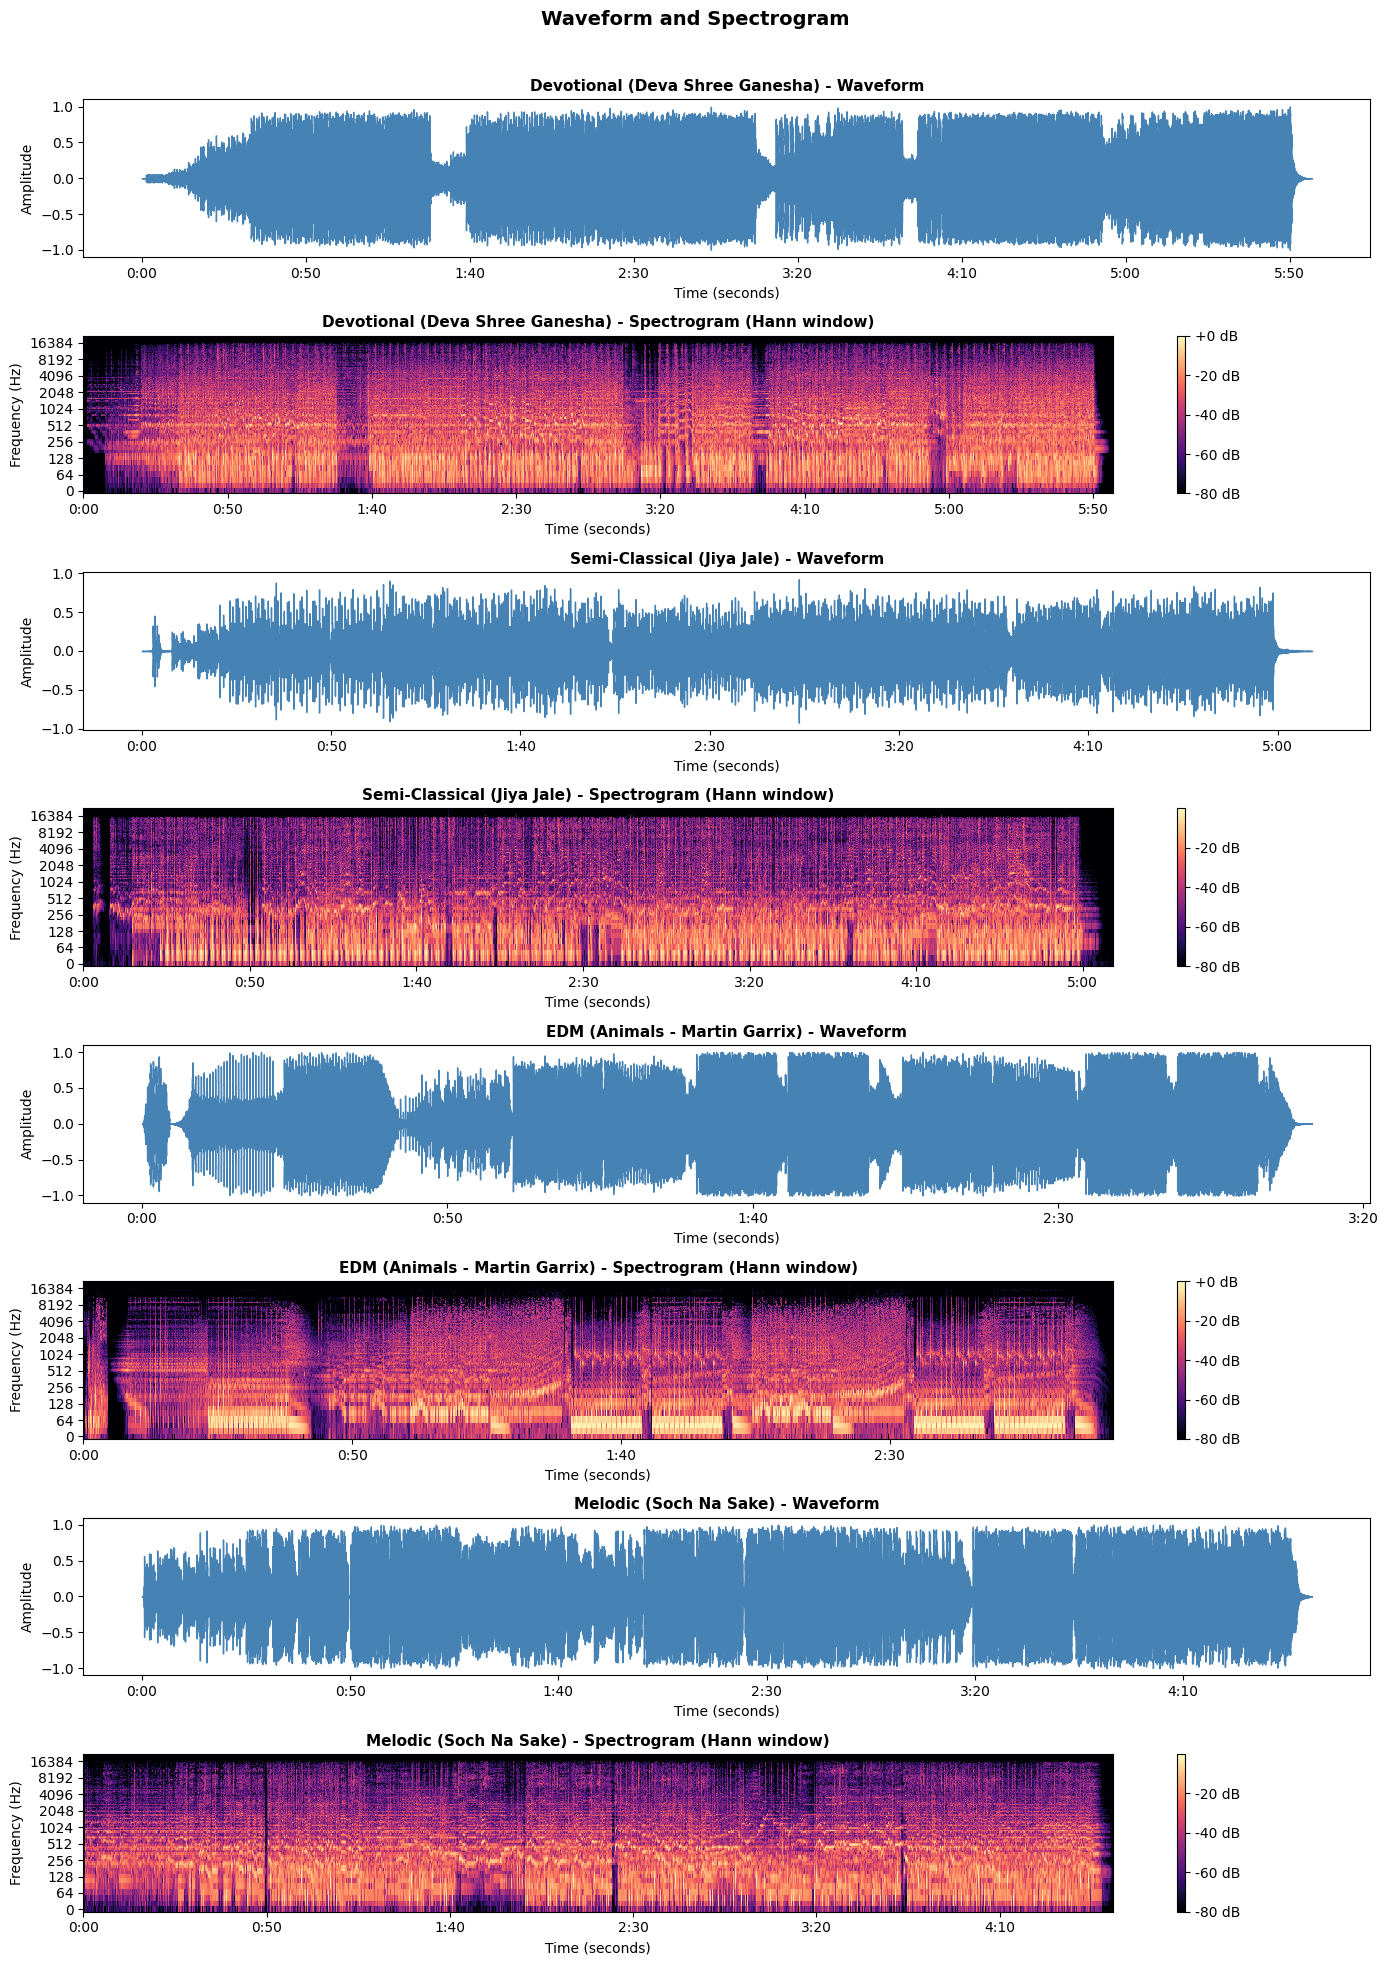

In [5]:
def plot_together_waveform_and_spectrogram(y, sr, title, ax_waveform, ax_spectrogram):
   
    librosa.display.waveshow(y, sr=sr, ax=ax_waveform, color='steelblue')
    ax_waveform.set_title(f"{title} - Waveform", fontsize=11, fontweight='bold')
    ax_waveform.set_xlabel("Time (seconds)")
    ax_waveform.set_ylabel("Amplitude")

    n_fft = 2048  # FFT window size
    hop_length = 512  # Hop size between frames
    window = 'hann'  
    
    # STFT with windowing
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    img = librosa.display.specshow(D_db, 
                                 x_axis='time', 
                                 y_axis='log',
                                 sr=sr,
                                 hop_length=hop_length,
                                 cmap='magma',
                                 ax=ax_spectrogram)
    
    ax_spectrogram.set_title(f"{title} - Spectrogram (Hann window)", fontsize=11, fontweight='bold')
    ax_spectrogram.set_xlabel("Time (seconds)")
    ax_spectrogram.set_ylabel("Frequency (Hz)")
    plt.colorbar(img, ax=ax_spectrogram, format="%+2.0f dB")



fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(14, 20))  
fig.suptitle("Waveform and Spectrogram", fontsize=14, fontweight='bold')

for i, (song_title, path) in enumerate(song_paths.items()):
    print(f"Processing: {song_title}")
    y, sr = preprocess_audio(path)
    ax_waveform = axes[i * 2] #waveform
    ax_spectrogram = axes[i * 2 + 1] #spectogram
    plot_together_waveform_and_spectrogram(y, sr, song_title, ax_waveform, ax_spectrogram)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

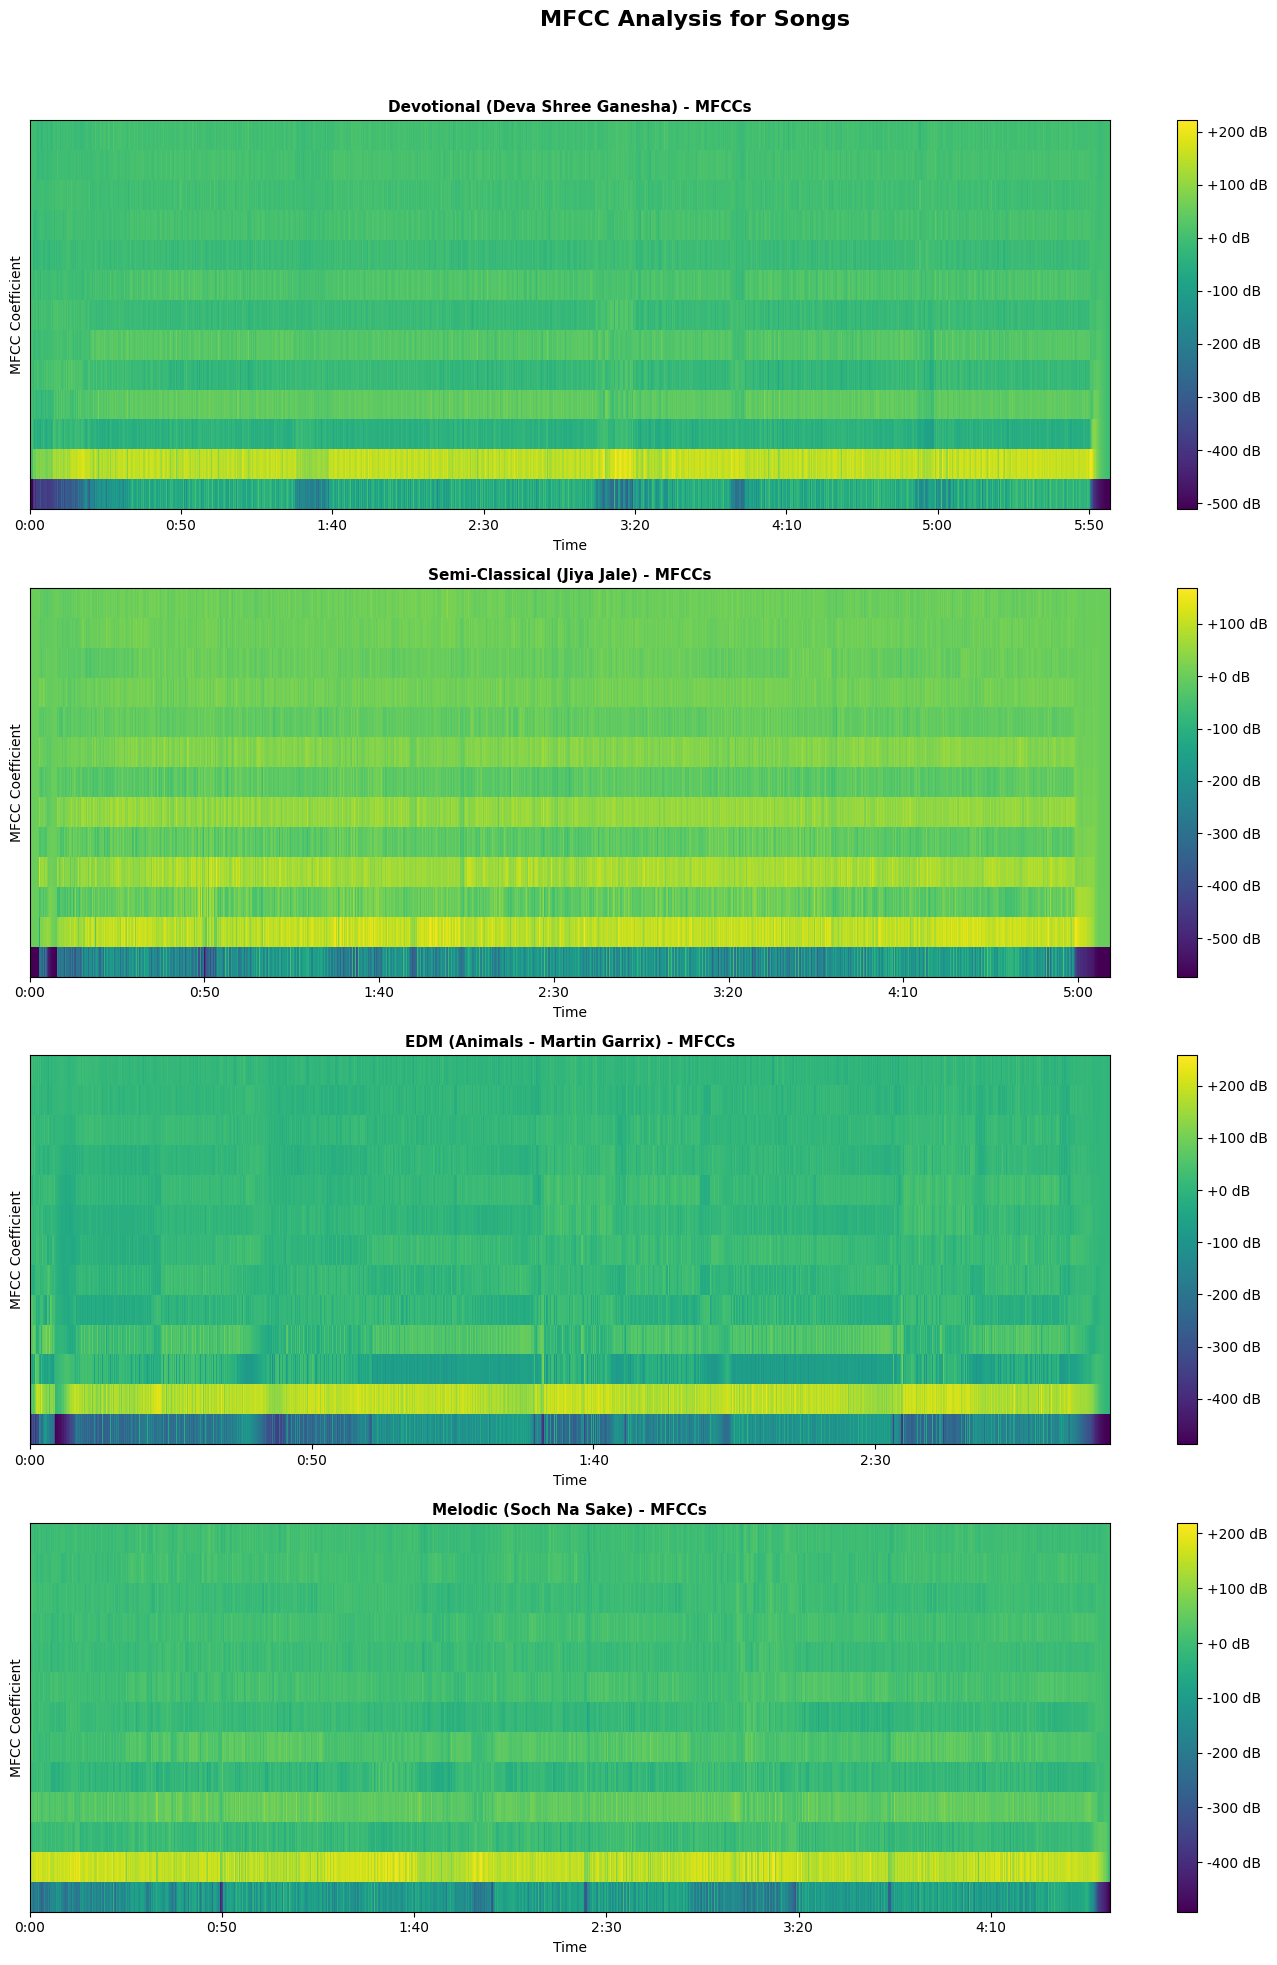

In [6]:
def plot_mfcc(y, sr, title, ax):

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    
    img = librosa.display.specshow(mfccs, x_axis='time', sr=sr, ax=ax, cmap='viridis')
    ax.set_title(f"{title} - MFCCs", fontsize=11, fontweight='bold')
    ax.set_xlabel("Time")
    ax.set_ylabel("MFCC Coefficient")
    plt.colorbar(img, ax=ax, format="%+2.0f dB")

fig_mfcc, axes_mfcc = plt.subplots(nrows=len(song_paths), ncols=1, figsize=(14, 5 * len(song_paths)))
fig_mfcc.suptitle("MFCC Analysis for Songs", fontsize=16, fontweight='bold')

for i, (title, path) in enumerate(song_paths.items()):
    y, sr = preprocess_audio(path)
    if y is None:
        continue
    ax = axes_mfcc[i] if len(song_paths) > 1 else axes_mfcc
    plot_mfcc(y, sr, title, ax)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [7]:
def compute_audio_metrics(y, sr):

    #RMSE 
    rms = librosa.feature.rms(y=y)[0]
    rmse_value = np.mean(rms)
    
    #SNR
    noise_rms = np.percentile(rms, 10)
    signal_rms = np.mean(rms)
    snr_value = 20 * np.log10(signal_rms / noise_rms) if noise_rms > 0 else np.inf
    
    #Spectral Leakage 
    spec_flatness = librosa.feature.spectral_flatness(y=y)[0]
    spectral_leakage_value = np.mean(spec_flatness)
    
    return rmse_value, snr_value, spectral_leakage_value

metrics = {}
for title, path in song_paths.items():
    y, sr = preprocess_audio(path)
    rmse_value, snr_value, spectral_leakage_value = compute_audio_metrics(y, sr)
    metrics[title] = {
        "RMSE": rmse_value,
        "SNR (dB)": snr_value,
        "Spectral Leakage": spectral_leakage_value
    }

metrics_df = pd.DataFrame(metrics).T
print("Computed Audio Metrics for Each Song:")
print(metrics_df)



Computed Audio Metrics for Each Song:
                                     RMSE   SNR (dB)  Spectral Leakage
Devotional (Deva Shree Ganesha)  0.205421  10.514883          0.006179
Semi-Classical (Jiya Jale)       0.090836   9.915790          0.004167
EDM (Animals - Martin Garrix)    0.279504  11.747831          0.000478
Melodic (Soch Na Sake)           0.240610   6.073724          0.000211
